In [1]:
import sys
sys.path.insert(0, '..')
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import functools

sigma = 2

from utils.kfp import diffusion_coeff, marginal_prob_std
from network.network import ScoreNet
from network.ddim_network import Model

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


error_tolerance = 1e-5

channels = 3
N = 50
H = 32
W = 32

In [2]:
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                input_channels=3,
                z=None,
                idx=0,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device) * eps
  #t = torch.tensor(np.linspace(1., eps, N))
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, input_channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, input_channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    time_steps += torch.tensor(list(range(sample.shape[0])))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    result = -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    return result

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"\nNumber of function evaluations: {res.nfev}")
  x = []
  for i in range(res.y.shape[1]):
    x.append(res.y[:, i].reshape(shape))
  return np.array(x)

In [3]:
# function for sampling on a thread
def diffuse_sample(samples, diffusion_coeff, marginal_prob_std):

  model_score = Model(H=H)
  file = f'../model_cifar_thread_all.pth'
  ckpt = torch.load(file, map_location="cpu")
  model_score.load_state_dict(ckpt)
  model_score.eval();

  sample_batch_size = 2
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size,
                  input_channels=3
                  )

  samples.append(output)

In [ ]:
#@title Sample each channel on a thread
#threads = [None] * channels
samples = []

diffuse_sample(samples, diffusion_coeff_fn, marginal_prob_std_fn)
# # diffuse all three channels concurrently
# for ch in range(channels):
#   threads[ch] = threading.Thread(target=diffuse_sample, args=[ch, samples, diffusion_coeff_fn, marginal_prob_std_fn])
#   threads[ch].start()

# for thread in threads:
#   thread.join()

samples = np.concatenate(samples, axis = 1)
# for i in range(samples.shape[0]):
#   print(f'{samples[i].mean(), samples[i].std()}')
#   plt.imshow(((samples[i] - samples[i].min())/(samples[i].max() - samples[i].min())).transpose(1, 2, 0))
#   plt.show()




Number of function evaluations: 260


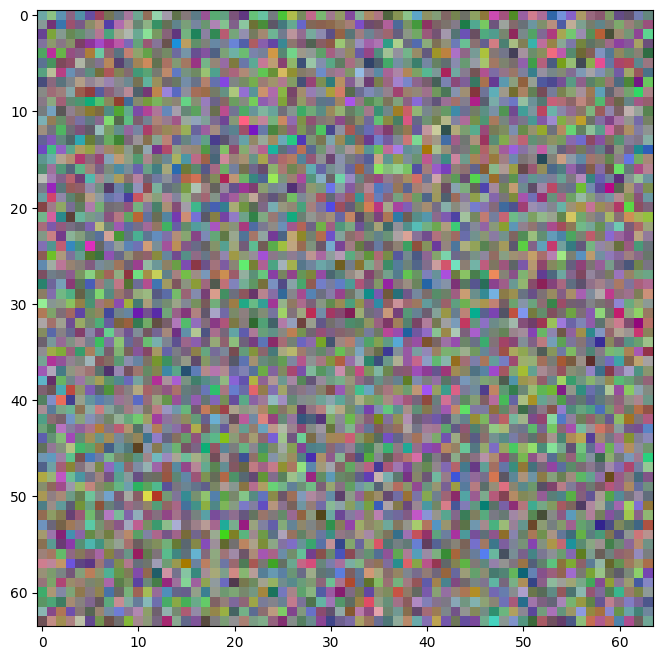

In [ ]:
sample_idx = 1

def get_frame(i):
  #return samples[i].transpose(1, 2, 0)
  return ((samples[i, sample_idx] - samples[i, sample_idx].min())/(samples[i, sample_idx].max() - samples[i, sample_idx].min())).transpose(1, 2, 0)

fig = plt.figure(figsize=(8,8));

im = plt.imshow(get_frame(0), animated=True)

def frame(i):
  if i >= len(samples):
    im.set_data(get_frame(-1));
  else:
    im.set_data(get_frame(i));

  return [im]

animation_fig = animation.FuncAnimation(fig, frame, frames=samples.shape[0] + 20, blit=False);

animation_fig.save("animation.gif", writer=animation.PillowWriter(fps=10));

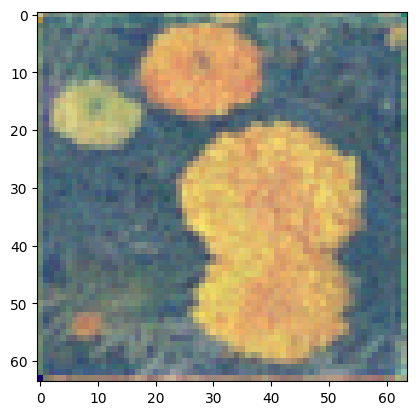

In [ ]:
plt.imshow(get_frame(-1))

In [ ]:
get_frame(-1)

array([[[0.10847176, 0.15152799, 0.23548844],
        [0.1002295 , 0.15060142, 0.2309414 ],
        [0.09779306, 0.15294584, 0.23758386],
        ...,
        [0.08910868, 0.16508814, 0.30070391],
        [0.07759463, 0.16727104, 0.29268003],
        [0.07565042, 0.16372728, 0.30433593]],

       [[0.104771  , 0.15862078, 0.24600776],
        [0.09517135, 0.1595475 , 0.25361734],
        [0.09740131, 0.16509578, 0.26657372],
        ...,
        [0.07890253, 0.1650281 , 0.3261223 ],
        [0.07317472, 0.16636842, 0.3193057 ],
        [0.08314142, 0.16862804, 0.31649235]],

       [[0.1055462 , 0.15886569, 0.25532286],
        [0.09402947, 0.16255959, 0.26408241],
        [0.09087542, 0.16395669, 0.2748159 ],
        ...,
        [0.07871089, 0.17000152, 0.33808987],
        [0.07004575, 0.16658201, 0.326648  ],
        [0.07592664, 0.16749218, 0.31901822]],

       ...,

       [[0.12349485, 0.20119414, 0.3528726 ],
        [0.11095828, 0.20058472, 0.36023546],
        [0.11223567, 0